In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import seaborn as sns

In [2]:
train = pd.read_csv('data/v1/train.csv')
test = pd.read_csv('data/v2/test.csv')

In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

Train dataset shape: (25737, 15)
Test dataset shape: (6006, 15)

Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25737 entries, 0 to 25736
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      25737 non-null  object 
 1   gender      25737 non-null  object 
 2   age         25737 non-null  float64
 3   height      25737 non-null  float64
 4   weight      25737 non-null  float64
 5   candj       25737 non-null  float64
 6   snatch      25737 non-null  float64
 7   deadlift    25737 non-null  float64
 8   backsq      25737 non-null  float64
 9   eat         25737 non-null  object 
 10  background  25737 non-null  object 
 11  experience  25737 non-null  object 
 12  schedule    25737 non-null  object 
 13  howlong     25737 non-null  object 
 14  total_lift  25737 non-null  float64
dtypes: float64(8), object(7)
memory usage: 2.9+ MB
None

Test dataset info:
<class 'pandas.core.frame.DataFr

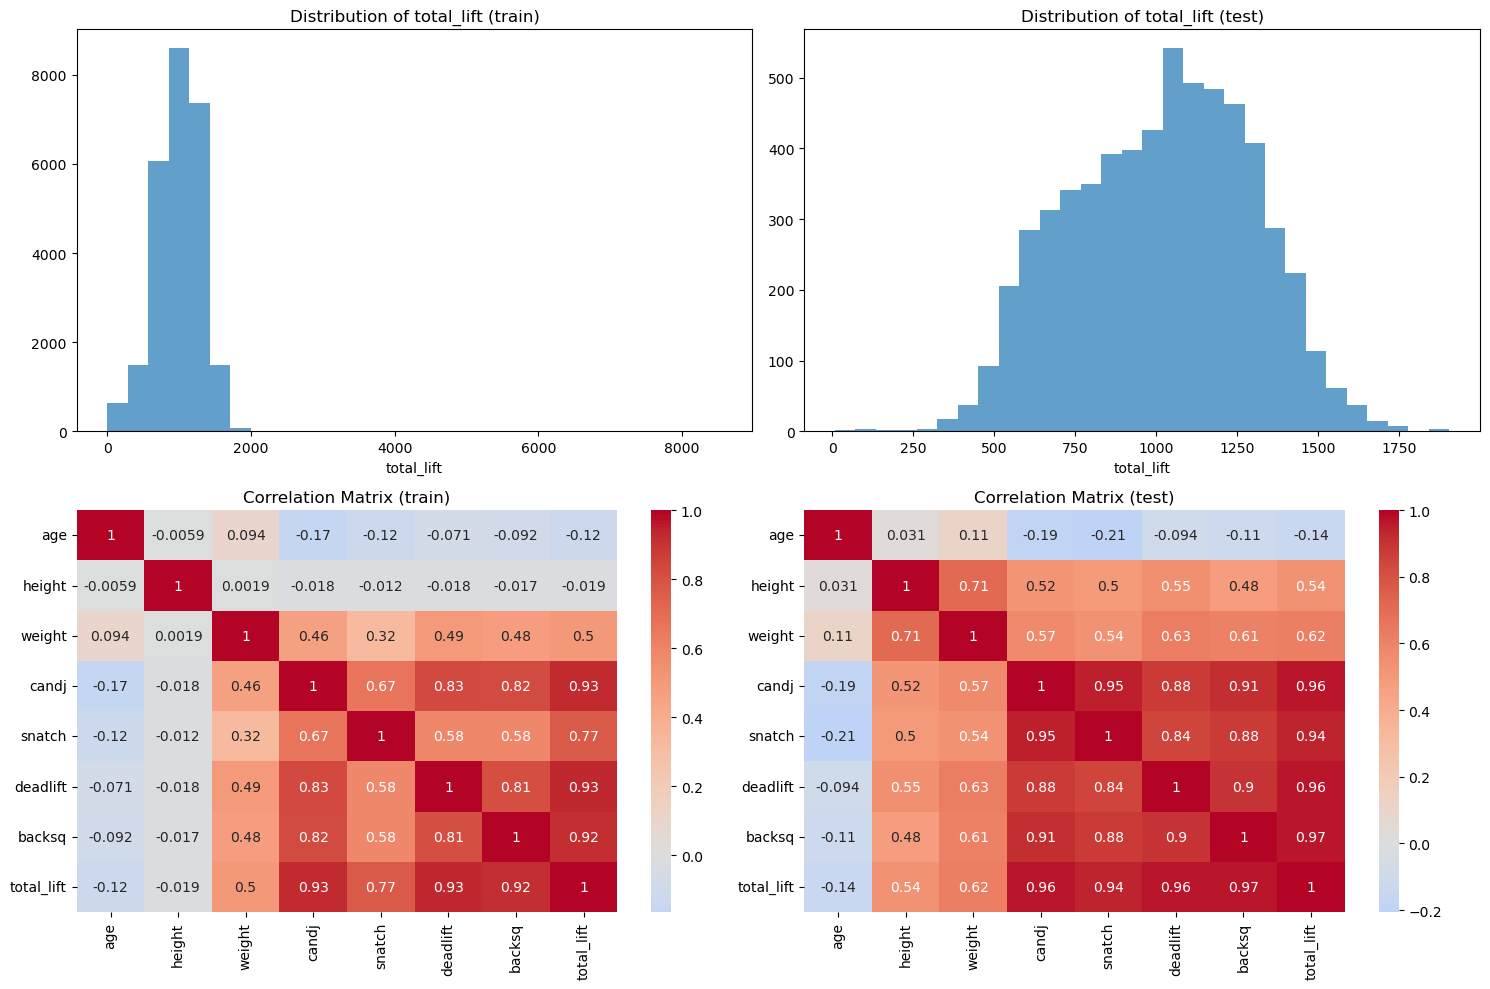

In [3]:

# Exploratory Data Analysis
print("Train dataset shape:", train.shape)
print("Test dataset shape:", test.shape)
print("\nTrain dataset info:")
print(train.info())
print("\nTest dataset info:")
print(test.info())

print("\nTrain dataset description:")
print(train.describe())
print("\nTest dataset description:")
print(test.describe())

print("\nMissing values in train:")
print(train.isnull().sum())
print("\nMissing values in test:")
print(test.isnull().sum())

# Plot distributions
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Target variable distribution
axes[0,0].hist(train['total_lift'], bins=30, alpha=0.7)
axes[0,0].set_title('Distribution of total_lift (train)')
axes[0,0].set_xlabel('total_lift')

axes[0,1].hist(test['total_lift'], bins=30, alpha=0.7)
axes[0,1].set_title('Distribution of total_lift (test)')
axes[0,1].set_xlabel('total_lift')

# Correlation matrix for train (numeric columns only)
corr_train = train.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr_train, annot=True, cmap='coolwarm', center=0, ax=axes[1,0])
axes[1,0].set_title('Correlation Matrix (train)')

# Correlation matrix for test (numeric columns only)
corr_test = test.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr_test, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('Correlation Matrix (test)')

plt.tight_layout()
plt.show()

In [4]:
train.head()

,region,gender,age,height,weight,candj,snatch,deadlift,backsq,eat,background,experience,schedule,howlong,total_lift
0,North Central,Male,31.0,70.0,175.0,195.0,145.0,315.0,295.0,I eat whatever is convenient|,I played youth or high school level sports|I p...,I began CrossFit with a coach (e.g. at an affi...,I usually only do 1 workout a day|,1-2 years|,950.0
1,Europe,Male,37.0,72.0,185.0,190.0,123.0,265.0,254.0,I eat quality foods but don't measure the amount|,I have no athletic background besides CrossFit|,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 3+ times a week|,2-4 years|,832.0
2,Africa,Male,41.0,76.0,220.0,165.0,115.0,285.0,200.0,I eat quality foods but don't measure the amount|,I have no athletic background besides CrossFit|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|I ty...,Less than 6 months|,765.0
3,Canada West,Female,34.0,67.0,135.0,135.0,95.0,210.0,185.0,I eat quality foods but don't measure the amou...,I played youth or high school level sports|I p...,I began CrossFit with a coach (e.g. at an affi...,I typically rest 4 or more days per month|,2-4 years|,625.0
4,Latin America,Male,19.0,81.0,286.0,215.0,165.0,385.0,255.0,I eat quality foods but don't measure the amou...,I have no athletic background besides CrossFit|,I began CrossFit with a coach (e.g. at an affi...,I usually only do 1 workout a day|I typically ...,Less than 6 months|,1020.0


In [5]:
# Create mapping for gender column
gender_mapping = {'Male': 0, 'Female': 1, '--': 1}

# Apply mapping to create new column in both datasets
train['upd_gender'] = train['gender'].map(gender_mapping)
test['upd_gender'] = test['gender'].map(gender_mapping)

# Display the mapping results
print("Mapping results for train dataset:")
print(train[['gender', 'upd_gender']].value_counts().sort_index())
print("\nMapping results for test dataset:")
print(test[['gender', 'upd_gender']].value_counts().sort_index())

Mapping results for train dataset:
gender  upd_gender
--      1                 1
Female  1              7134
Male    0             18602
Name: count, dtype: int64

Mapping results for test dataset:
gender  upd_gender
Female  1             1686
Male    0             4320
Name: count, dtype: int64


In [6]:
# Create mapping for howlong column with partial matching
def map_howlong(value):
    if '4+ years' in value:
        return 4
    elif '2-4 years' in value:
        return 3
    elif '1-2 years' in value:
        return 2
    elif '6-12 months' in value:
        return 1
    elif 'Less than 6 months' in value:
        return 0
    else:
        return None

# Apply mapping to create new column in both datasets
train['upd_howlong'] = train['howlong'].apply(map_howlong)
test['upd_howlong'] = test['howlong'].apply(map_howlong)

# Display the mapping results
print("Mapping results for train dataset:")
print(train[['howlong', 'upd_howlong']].value_counts().sort_index())
print("\nMapping results for test dataset:")
print(test[['howlong', 'upd_howlong']].value_counts().sort_index())

Mapping results for train dataset:
howlong                                                                         upd_howlong
1-2 years|                                                                      2.0            8858
1-2 years|2-4 years|                                                            3.0             127
1-2 years|2-4 years|4+ years|                                                   4.0               1
1-2 years|4+ years|                                                             4.0               5
1-2 years|Decline to answer|                                                    2.0               3
2-4 years|                                                                      3.0            8419
2-4 years|4+ years|                                                             4.0              65
2-4 years|Decline to answer|                                                    3.0               3
4+ years|                                                                

In [8]:
train.head()

,region,gender,age,height,weight,candj,snatch,deadlift,backsq,eat,background,experience,schedule,howlong,total_lift,upd_gender,upd_howlong
0,North Central,Male,31.0,70.0,175.0,195.0,145.0,315.0,295.0,I eat whatever is convenient|,I played youth or high school level sports|I p...,I began CrossFit with a coach (e.g. at an affi...,I usually only do 1 workout a day|,1-2 years|,950.0,0,2.0
1,Europe,Male,37.0,72.0,185.0,190.0,123.0,265.0,254.0,I eat quality foods but don't measure the amount|,I have no athletic background besides CrossFit|,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 3+ times a week|,2-4 years|,832.0,0,3.0
2,Africa,Male,41.0,76.0,220.0,165.0,115.0,285.0,200.0,I eat quality foods but don't measure the amount|,I have no athletic background besides CrossFit|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|I ty...,Less than 6 months|,765.0,0,0.0
3,Canada West,Female,34.0,67.0,135.0,135.0,95.0,210.0,185.0,I eat quality foods but don't measure the amou...,I played youth or high school level sports|I p...,I began CrossFit with a coach (e.g. at an affi...,I typically rest 4 or more days per month|,2-4 years|,625.0,1,3.0
4,Latin America,Male,19.0,81.0,286.0,215.0,165.0,385.0,255.0,I eat quality foods but don't measure the amou...,I have no athletic background besides CrossFit|,I began CrossFit with a coach (e.g. at an affi...,I usually only do 1 workout a day|I typically ...,Less than 6 months|,1020.0,0,0.0


In [9]:
# Select only numeric columns for training
numeric_cols = ['age', 'upd_gender', 'height', 'weight', 'upd_howlong'] #leakage - 'candj', 'snatch', 'deadlift', 'backsq',
X_train, y_train = train[numeric_cols], train['total_lift']
X_test, y_test = test[numeric_cols], test['total_lift']
model = RandomForestRegressor(random_state=42).fit(X_train, y_train)
preds = model.predict(X_test)
metrics = {
  "MAE": mean_absolute_error(y_test, preds),
  "RMSE": root_mean_squared_error(y_test, preds),
  "R2": r2_score(y_test, preds)
}

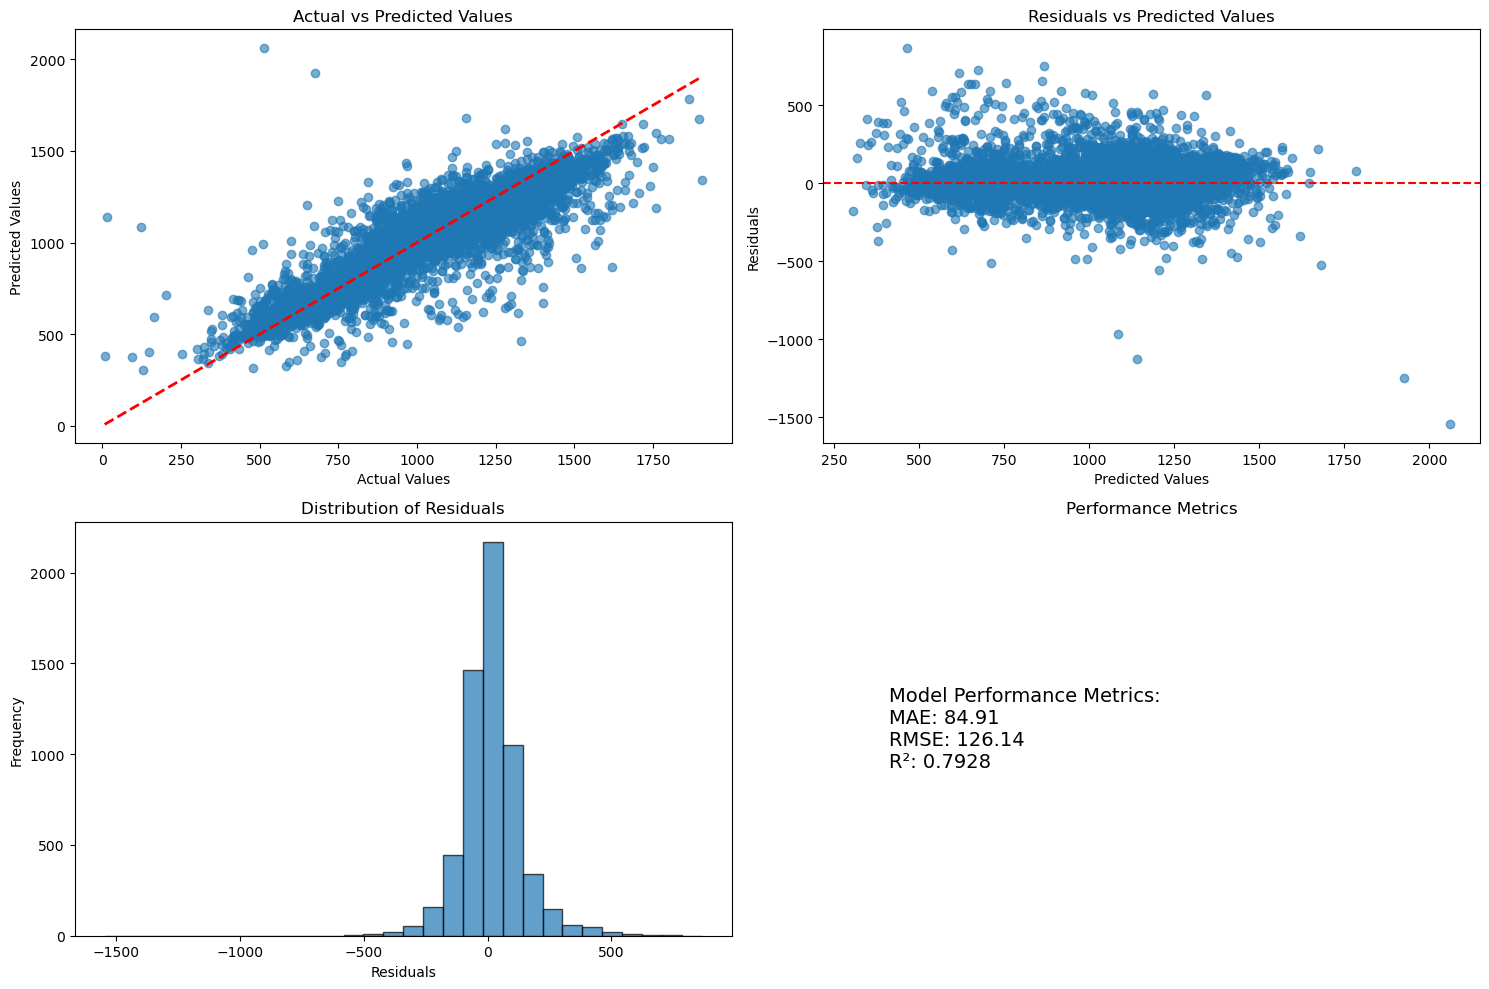

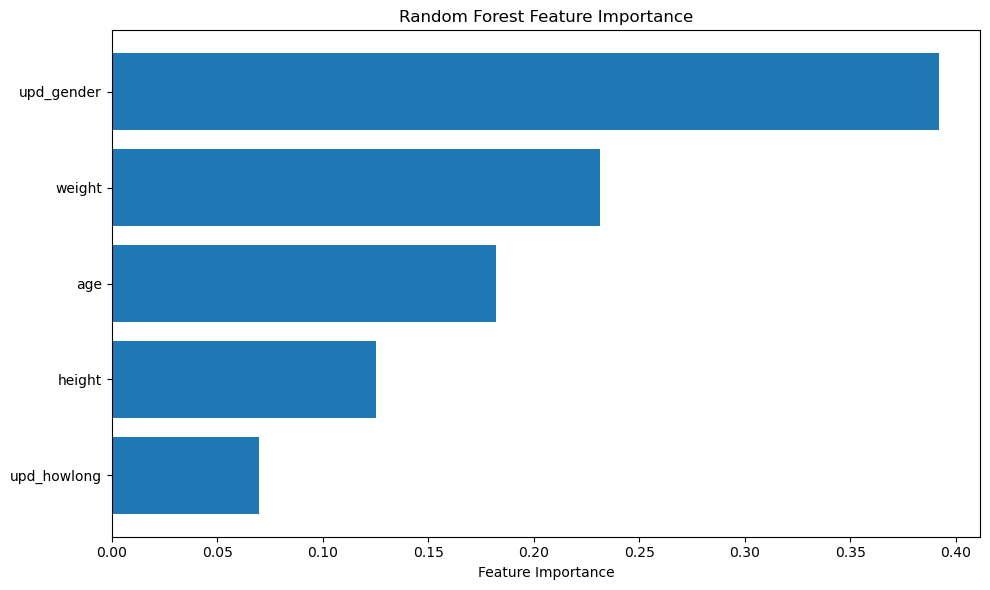

In [10]:
import matplotlib.pyplot as plt

# Create performance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Actual vs Predicted scatter plot
axes[0,0].scatter(y_test, preds, alpha=0.6)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Values')
axes[0,0].set_ylabel('Predicted Values')
axes[0,0].set_title('Actual vs Predicted Values')

# 2. Residuals plot
residuals = y_test - preds
axes[0,1].scatter(preds, residuals, alpha=0.6)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Predicted Values')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Residuals vs Predicted Values')

# 3. Distribution of residuals
axes[1,0].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Residuals')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Residuals')

# 4. Metrics display
metrics_text = f"""Model Performance Metrics:
MAE: {metrics['MAE']:.2f}
RMSE: {metrics['RMSE']:.2f}
R²: {metrics['R2']:.4f}"""
axes[1,1].text(0.1, 0.5, metrics_text, fontsize=14, verticalalignment='center')
axes[1,1].set_xlim(0, 1)
axes[1,1].set_ylim(0, 1)
axes[1,1].axis('off')
axes[1,1].set_title('Performance Metrics')

plt.tight_layout()
plt.show()

# Feature importance plot
feature_importance = pd.DataFrame({
    'feature': numeric_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()